<a href="https://colab.research.google.com/github/hufsaim/T10306201/blob/master/notebook_2023/Lab09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder, DatasetFolder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2


/home/oem/anaconda3/envs/hwasan/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/oem/anaconda3/envs/hwasan/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feed

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [3]:
# device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
# print(device)

## Download MNIST and Prepare Data Loader

In [115]:
path0 = '.'

transform = v2.Compose(
    [
        v2.ToTensor(),
        v2.Grayscale(),
        v2.ToDtype(torch.float32),  # Normalize expects float input
        v2.Resize(size=(14,14)),
        v2.Pad(padding=7, fill=0, padding_mode='constant'),
        v2.CenterCrop(size=(28, 28)),
        v2.GaussianBlur(kernel_size=1, sigma=(0.1, 2.0)),
        # v2.RandomAdjustSharpness(sharpness_factor=0.5, p=1.0),
        v2.RandomAffine(degrees=60, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1),
        v2.RandomInvert(p=1.0),
        # v2.Lambda(lambda x: (x > 0.6).float()),
        ]
    )

transform_val = v2.Compose(
    [
        v2.ToTensor(),
        v2.Grayscale(),
        v2.ToDtype(torch.float32),  # Normalize expects float input
        v2.CenterCrop(size=(28, 28)),
        ]
    )

transform_test = v2.Compose(
    [
        v2.ToTensor(),
        v2.Grayscale(),
        v2.Lambda(lambda x: (x > 0.7).float()),
        v2.Resize(size=(32, 32)),
        v2.CenterCrop(28),
    ])

path_test = '/home/oem/hufsbaby/ycm/HW6/hufs_mnist_2023' # 본인의 경로로 변경해주세요
data_test = ImageFolder(root=path_test, transform=transform_test)

mnist_train = torchvision.datasets.MNIST(path0, train=True, transform=transform, target_transform=None, download=True)
mnist_valid = torchvision.datasets.MNIST(path0, train=False, transform=transform_val, target_transform=None, download=True)
def get_mnist_labels(labels):
    text_labels = ['0', '1', '2', '3', '4',
                   '5', '6', '7', '8', '9']
    return [text_labels[int(i)] for i in labels]

# defining data_iter, linreg. model, loss, sgd
batch_size = 100
num_workers = 0
train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
valid_iter = DataLoader(data_test, batch_size, shuffle=False, num_workers=num_workers)

In [116]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
                 ToTensor()
                 Grayscale(num_output_channels=1)
                 ToDtype()
                 Resize(size=[14, 14], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                 Pad(padding=7, fill=0, padding_mode=constant)
                 CenterCrop(size=(28, 28))
                 GaussianBlur(kernel_size=(1, 1), sigma=(0.1, 2.0))
                 RandomAffine(degrees=[-60.0, 60.0], translate=(0.1, 0.1), scale=(0.9, 1.1), shear=[-0.1, 0.1], interpolation=InterpolationMode.NEAREST, fill=0)
                 RandomInvert(p=1.0)
           )

In [117]:
mnist_valid

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
                 ToTensor()
                 Grayscale(num_output_channels=1)
                 ToDtype()
                 CenterCrop(size=(28, 28))
           )

In [118]:
data_test

Dataset ImageFolder
    Number of datapoints: 280
    Root location: /home/oem/hufsbaby/ycm/HW6/hufs_mnist_2023
    StandardTransform
Transform: Compose(
                 ToTensor()
                 Grayscale(num_output_channels=1)
                 Lambda(<lambda>, types=['object'])
                 Resize(size=[32, 32], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                 CenterCrop(size=(28, 28))
           )

torch.Size([100])
torch.Size([100, 1, 28, 28])


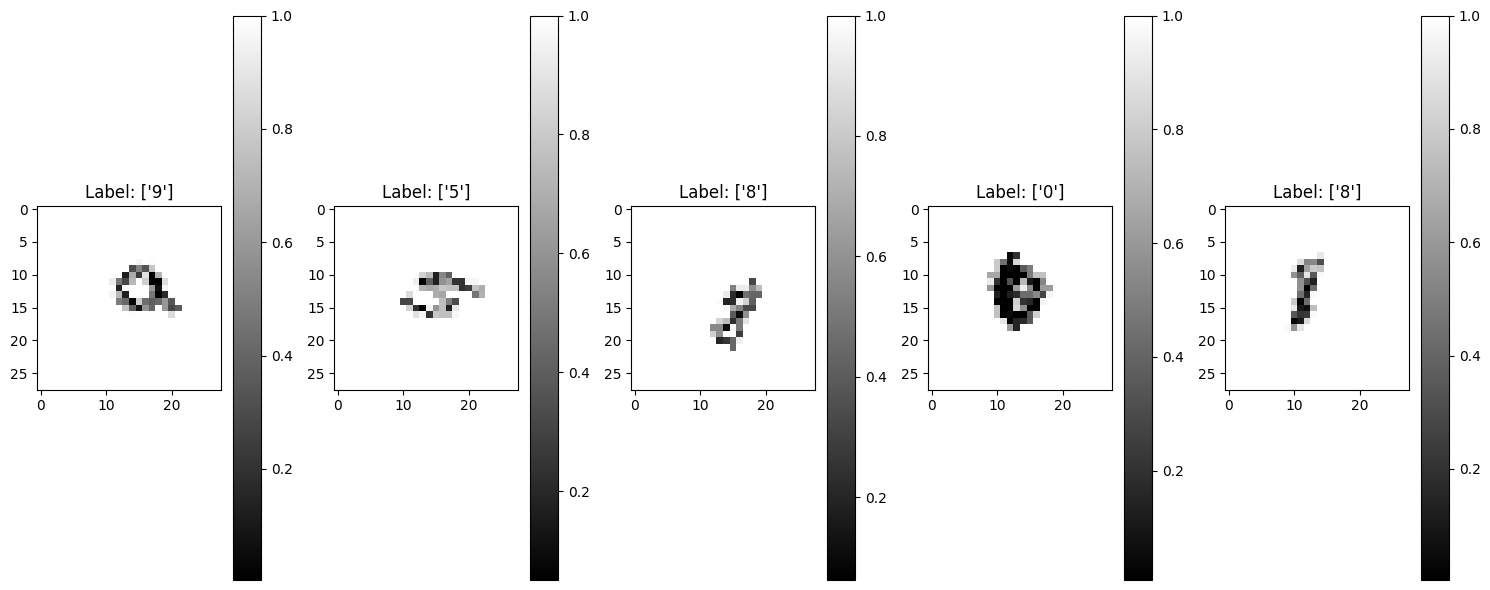

torch.Size([100])
torch.Size([100, 1, 28, 28])


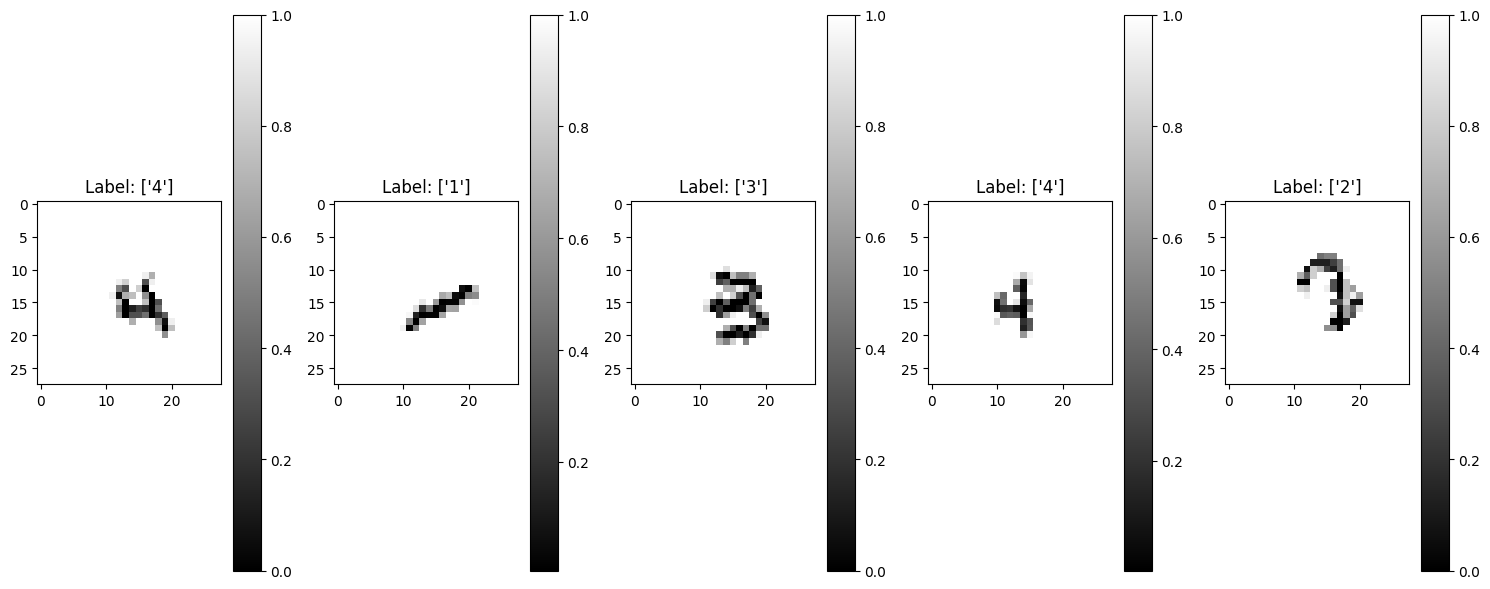

torch.Size([100])
torch.Size([100, 1, 28, 28])


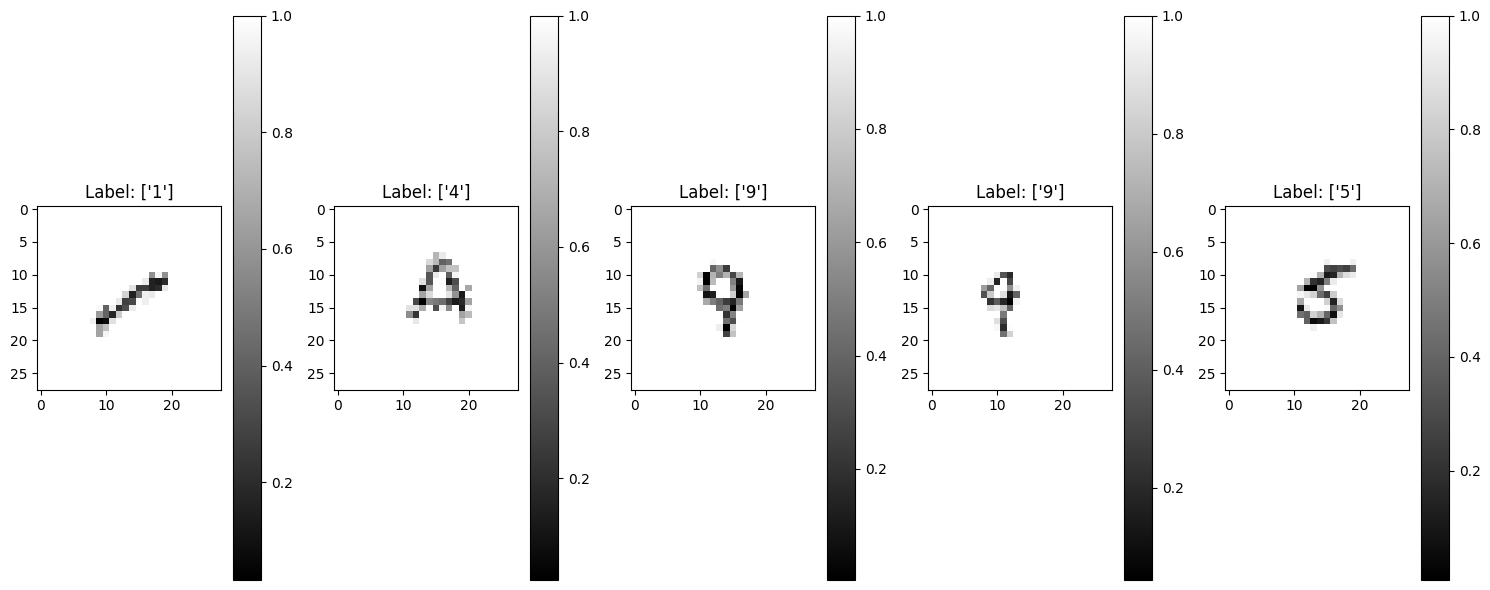

torch.Size([100])
torch.Size([100, 1, 28, 28])


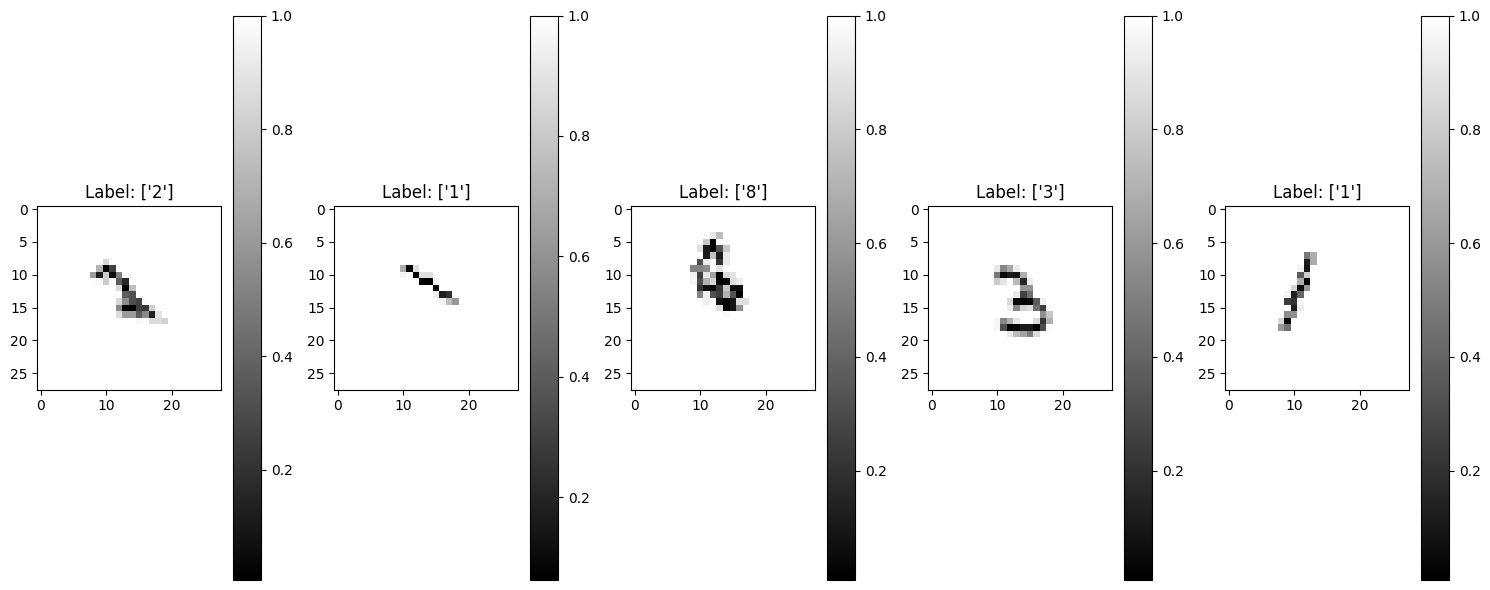

torch.Size([100])
torch.Size([100, 1, 28, 28])


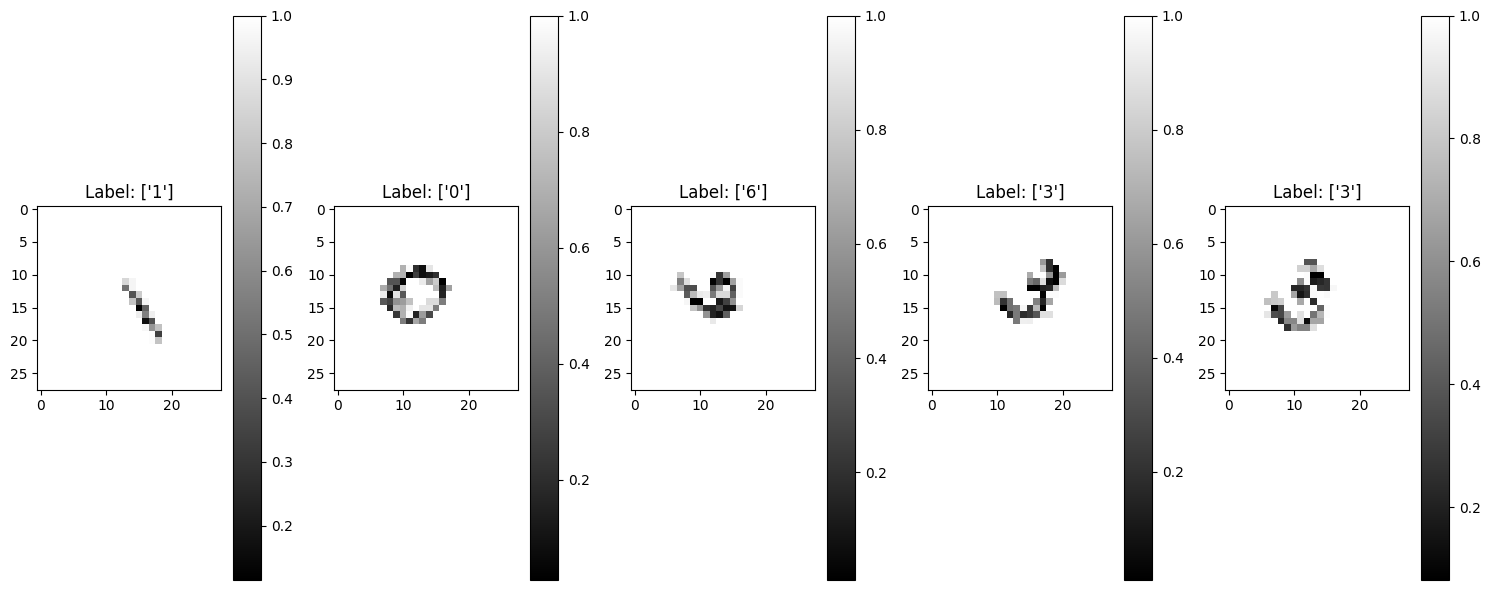

In [119]:
import math

count = 0
num_images_per_row = 5  # 각 행당 이미지 개수

for images, labels in train_iter:
    print(labels.shape)
    print(images.shape)
    
    plt.figure(figsize=(15, 6))
    for i in range(num_images_per_row):
        I = images[i].numpy()
        plt.subplot(1, num_images_per_row, i + 1)
        plt.imshow(I[0], cmap='gray')
        plt.colorbar()
        label = get_mnist_labels([labels[i]])
        plt.title(f'Label: {label}')
    plt.tight_layout()
    plt.show()

    count += 1
    if count == 5:  # 8번째까지 출력
        break


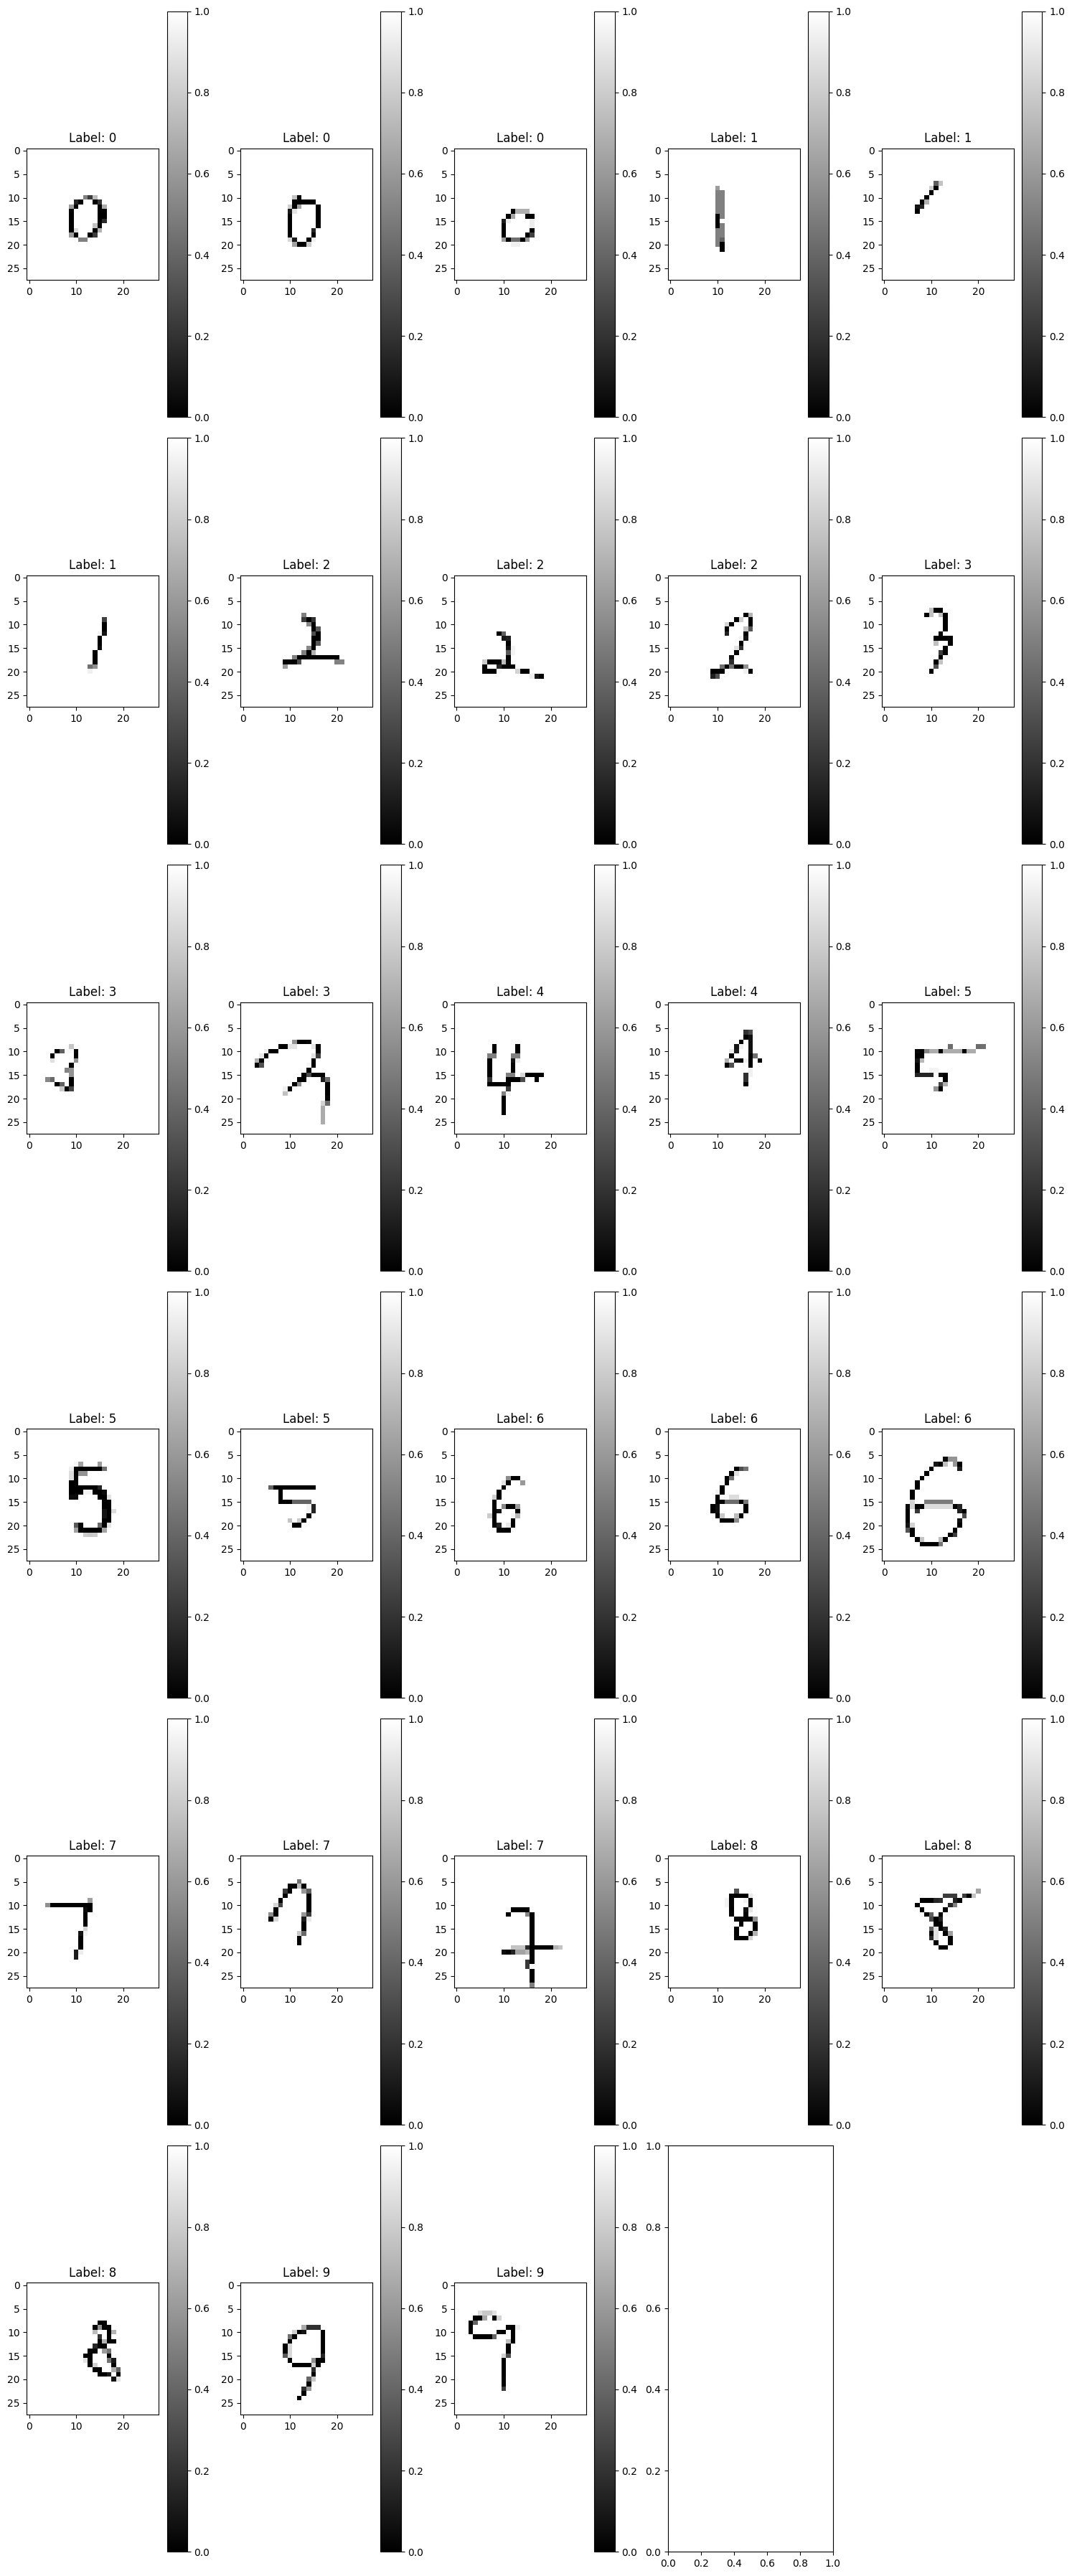

In [120]:
import math

transform_test = v2.Compose(
    [
        v2.ToTensor(),
        v2.Grayscale(),
        v2.Lambda(lambda x: (x > 0.7).float()),
        v2.Resize(size=(32, 32)),
        v2.CenterCrop(28),
    ])

path_test = '/home/oem/hufsbaby/ycm/HW6/hufs_mnist_2023' # 본인의 경로로 변경해주세요
data_test = ImageFolder(root=path_test, transform=transform_test)

# 시각화할 이미지 개수 지정
num_images = 30
images_per_row = 5

num_rows = math.ceil(num_images / images_per_row)

plt.figure(figsize=(15, 6 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, images_per_row, i + 1)
    n = i * 10  # 10씩 증가하면서 이미지 인덱스 선택
    if n >= len(data_test):
        break
    X = data_test[n][0].unsqueeze(0)
    y = data_test[n][1]
    plt.imshow(X[0, 0], cmap='gray')
    plt.title(f'Label: {y}')
    plt.colorbar()

plt.tight_layout()
plt.show()


## illustration of torchivision transforms

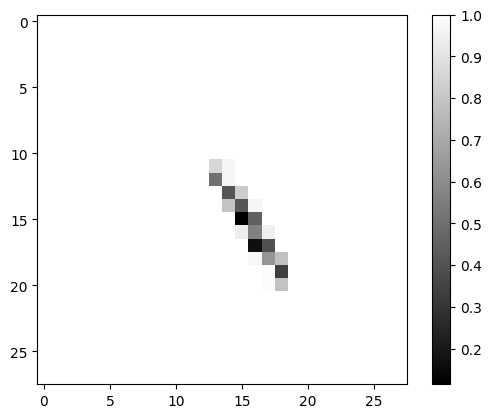

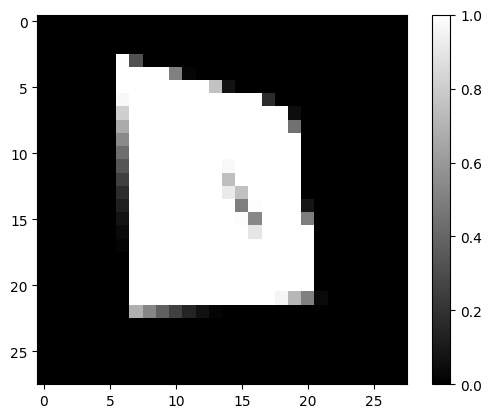

In [121]:
t_imges = v2.RandomPerspective(distortion_scale=0.6, p=1.0)(images)
plt.imshow(images[0,0],cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(t_imges[0,0],cmap='gray')
plt.colorbar()
plt.show()

## Network

In [122]:
net = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=16*5*5, out_features=120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)
net = net.to(device)
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [123]:
X = torch.randn(size=(1,1,28,28), dtype = torch.float32)
X = X.to(device)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


## Hyperparameters

In [129]:
# setting hyper-parameters
learning_rate = 42e-4
num_epochs = 10

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.Adam(net.parameters(),lr=learning_rate) # sgd

## Train a Model

In [125]:
net.load_state_dict(torch.load('my_best_model_90.000.pth'))

<All keys matched successfully>

epoch #: 1 train loss:  0.23356369018554687 train accuracy:  92.83999633789062 valid accuracy:  83.21428680419922
epoch #: 2 train loss:  0.22895779927571613 train accuracy:  92.92666625976562 valid accuracy:  84.28571319580078
epoch #: 3 train loss:  0.22564524332682293 train accuracy:  93.13500213623047 valid accuracy:  85.35713958740234


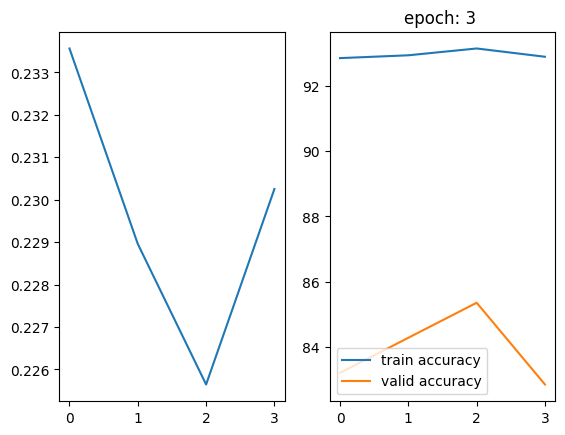

epoch #: 4 train loss:  0.2302527618408203 train accuracy:  92.88166809082031 valid accuracy:  82.85713958740234
epoch #: 5 train loss:  0.2243560028076172 train accuracy:  93.07499694824219 valid accuracy:  83.92857360839844
epoch #: 6 train loss:  0.2220068868001302 train accuracy:  93.18333435058594 valid accuracy:  86.07142639160156
epoch #: 7 train loss:  0.22034566243489584 train accuracy:  93.25166320800781 valid accuracy:  83.21428680419922
epoch #: 8 train loss:  0.21525588989257813 train accuracy:  93.4183349609375 valid accuracy:  85.0
epoch #: 9 train loss:  0.21465184529622397 train accuracy:  93.44166564941406 valid accuracy:  85.71428680419922
epoch #: 10 train loss:  0.22005986531575522 train accuracy:  93.30500030517578 valid accuracy:  87.14286041259766


In [130]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X,y = X.to(device),y.to(device) # GPU
    alg.zero_grad()
    y_hat=net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    l.backward()
    alg.step()

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,(100*correct.cpu())/len(mnist_train))

  correct = 0
  for X,y in valid_iter:
    X,y = X.to(device),y.to(device)
    y_hat = net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()

  accs_valid = np.append(accs_valid,(100*correct.cpu())/len(data_test))

  if epoch%8 == 3:
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.show()
  
  print('epoch #:',epoch+1,'train loss: ',loss_train[-1],'train accuracy: ',accs_train[-1],'valid accuracy: ',accs_valid[-1])
  if accs_valid[-1]>90:
    torch.save(net.state_dict(),'my_best_model_{:.3f}.pth'.format(accs_valid[-1]))
    print('model saved with accuracy: ',accs_valid[-1])

In [131]:
torch.save(net.state_dict(),f'my_best_model_rotate_87.142.pth')

## Results (Validation Set)

In [91]:
i = 0
y_all=[]
y_hat_all=[]
for X,y in valid_iter:
  i=i+1
  X=X.to(device)
  y_hat = net(X)
  y_hat = y_hat.argmax(dim=1)
  y_all.append(y)
  y_hat_all.append(y_hat)
y_all = torch.cat(y_all,dim=0)
y_hat_all = torch.cat(y_hat_all,dim=0)

/home/oem/anaconda3/envs/hwasan/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


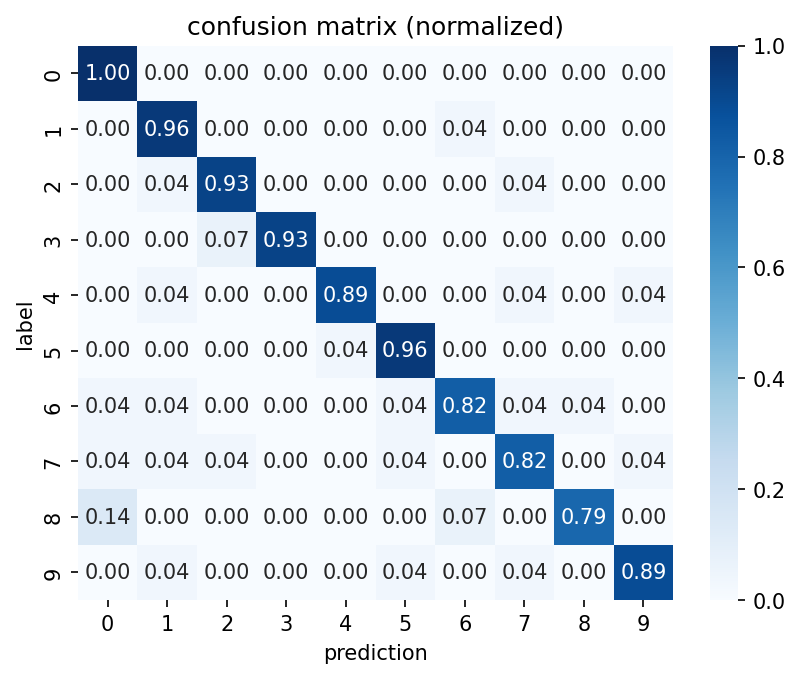

In [92]:
cf = confusion_matrix(y_all.numpy(),y_hat_all.cpu().numpy())
plt.figure(dpi=150)
cf = cf/np.sum(cf,axis=1)
sns.heatmap(cf,annot=True,cmap='Blues',fmt=".2f")
plt.title('confusion matrix (normalized)')
plt.ylabel('label')
plt.xlabel('prediction')
plt.show()

## Results (External Test Set)

In [86]:
transform_test = v2.Compose(
    [
        v2.ToTensor(),
        v2.Grayscale(),
        v2.Lambda(lambda x: (x > 0.7).float()),
        v2.Resize(size=(32, 32)),
        v2.CenterCrop(28),
    ])

/home/oem/anaconda3/envs/hwasan/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [97]:
path_test = '/home/oem/hufsbaby/ycm/HW6/hufs_mnist_2023' # replace with your path
data_test = ImageFolder(root=path_test,transform=transform_test)
net.load_state_dict(torch.load(f'my_best_model_90.000.pth'))

<All keys matched successfully>

/home/oem/anaconda3/envs/hwasan/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


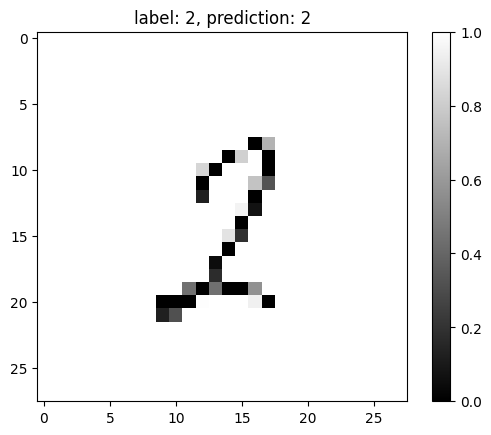

In [88]:
n=80
X = data_test[n][0].unsqueeze(0)
y = data_test[n][1]
y_hat = net(X.to(device))
y_hat = y_hat.argmax(dim=1)
plt.imshow(X[0,0],cmap='gray')
plt.title(f'label: {y}, prediction: {y_hat.cpu().numpy()[0]}')
plt.colorbar()
plt.show()

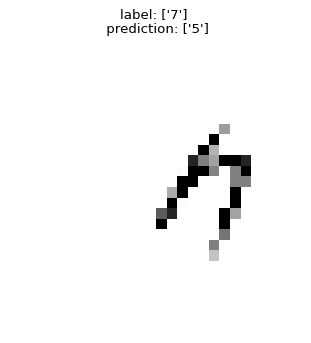

accuracy: 90.0
number of incorrect predictions: 28
number of correct predictions: 252


In [89]:
#len(data_test)
results = np.zeros((2,len(data_test)))
num_incorrect = 0
flag_plot = 1
for n in range(len(data_test)):
  X = data_test[n][0].unsqueeze(0)
  y = data_test[n][1]
  y_hat = net(X.to(device))
  y_hat = y_hat.argmax(dim=1)

  results[0,n] = y
  results[1,n] = y_hat
  if y_hat != y:
    num_incorrect+=1
    if num_incorrect%16==0:
      if flag_plot == 1:
        plt.figure(dpi=80)
        plt.imshow(X[0].cpu().squeeze(),cmap='gray')
        plt.title('label: %s \n prediction: %s'%(get_mnist_labels([y]),get_mnist_labels([y_hat])))
        plt.axis('off')
        plt.show()

acc = 100*(len(data_test)-num_incorrect)/len(data_test)
print(f'accuracy: {acc}')
print(f'number of incorrect predictions: {num_incorrect}')
print(f'number of correct predictions: {len(data_test)-num_incorrect}')

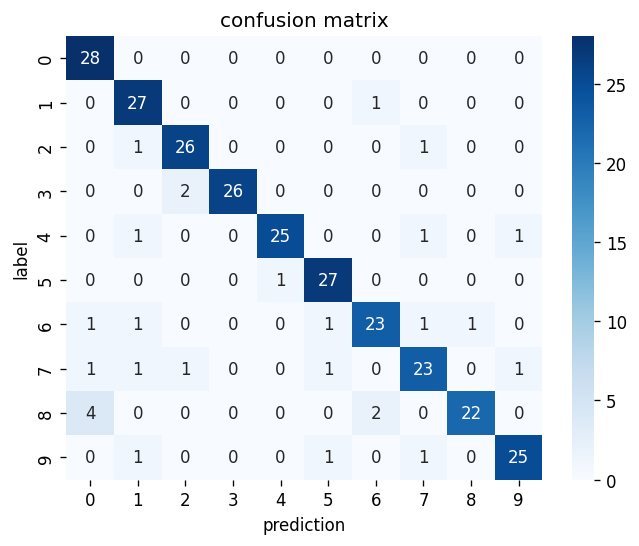

In [90]:
cf = confusion_matrix(results[0,:],results[1,:])
plt.figure(dpi=120)
sns.heatmap(cf,annot=True,cmap='Blues')
plt.title('confusion matrix')
plt.ylabel('label')
plt.xlabel('prediction')
plt.show()

## Homework
- transform, model, hyperparameter 등을 적절하게 수정하여 external test set에 대한 accuracy를 높여보자.